# Bagging

## Setting up

- Wine data
- Binary classification (filter class 0 and 1)
- 2 features ('alcohol','malic_acid')

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_wine
import matplotlib.pyplot as plt

#Load data
dataObj = load_wine()
X = dataObj.data
y = dataObj.target

# Create DataFrame with features
dfori = pd.DataFrame(X)
dfori.columns = dataObj.feature_names

# Add class column
dfori.insert(loc=0, column="Class", value=y)

dfori['Class'].value_counts()

1    71
0    59
2    48
Name: Class, dtype: int64

In [2]:
#Filter class 0 and 1
filt = (dfori['Class'] == 0) | (dfori['Class'] == 1)
df = dfori.loc[filt]
display(df.head())
df['Class'].value_counts()

,Class,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,0,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,0,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,0,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,0,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


1    71
0    59
Name: Class, dtype: int64

In [3]:
# Extract two features 
X = df[['alcohol','malic_acid']].values
y = df['Class'].values

In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1, stratify=y)

## Dicision tree

In [5]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)

tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)

y_test_pred = tree.predict(X_test)

In [6]:
from sklearn.metrics import accuracy_score, precision_score ,recall_score, f1_score

def calc_score(y_true, y_pred):
    ACC = accuracy_score(y_true=y_true, y_pred=y_pred)
    PRE = precision_score(y_true=y_true, y_pred=y_pred, zero_division=1)
    REC = recall_score(y_true=y_true, y_pred=y_pred, zero_division=1)
    F1 = f1_score(y_true=y_true, y_pred=y_pred, zero_division=1)
    # print(f"ACC:{ACC:6.3f} PRE:{PRE:6.3f} REC:{REC:6.3f} F1:{REC:6.3f}")
    return (ACC, PRE, REC, F1)

In [7]:
df1 = pd.DataFrame()

names = ['tree (train)', 'tree (test)']
y_trues = [y_train, y_test]
y_preds = [y_train_pred, y_test_pred]

for y_true, y_pred, name in zip(y_trues, y_preds, names):

    ACC, PRE, REC, F1 = calc_score(y_true, y_pred)
    data = {'clf': name,
            'ACC': f"{ACC:6.3f}" ,
            'PRE': f"{PRE:6.3f}" ,
            'REC': f"{REC:6.3f}" ,
            'F1': f"{F1:6.3f}"}
    df1 = df1.append(data, ignore_index=True)
    
df1 = df1.set_index(["clf"])
display(df1)

,ACC,F1,PRE,REC
clf,,,,
tree (train),1.000,1.000,1.000,1.000
tree (test),0.865,0.881,0.839,0.929


## Decision tree with bagging

In [8]:
from sklearn.ensemble import BaggingClassifier

base = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)

bag = BaggingClassifier(base_estimator=base,
                        n_estimators=500, 
                        max_samples=1.0, #This results in the same number of observations as the original data.
                        max_features=1.0, #Use the same number of features as the original data.
                        bootstrap=True, #Sample are drawn with replacement.
                        bootstrap_features=False, #Feature are drawn without replcaement.
                        n_jobs=1, 
                        random_state=1)


bag.fit(X_train, y_train)

y_train_pred = bag.predict(X_train)

y_test_pred = bag.predict(X_test)

In [9]:
df2 = pd.DataFrame()

names = ['bag (train)', 'bag (test)']
y_trues = [y_train, y_test]
y_preds = [y_train_pred, y_test_pred]

for y_true, y_pred, name in zip(y_trues, y_preds, names):

    ACC, PRE, REC, F1 = calc_score(y_true, y_pred)
    data = {'clf': name,
            'ACC': f"{ACC:6.3f}" ,
            'PRE': f"{PRE:6.3f}" ,
            'REC': f"{REC:6.3f}" ,
            'F1': f"{F1:6.3f}"}
    df2 = df2.append(data, ignore_index=True)
    
df2 = df2.set_index(["clf"])
dfclf = pd.concat((df1,df2))
display(dfclf)

,ACC,F1,PRE,REC
clf,,,,
tree (train),1.000,1.000,1.000,1.000
tree (test),0.865,0.881,0.839,0.929
bag (train),1.000,1.000,1.000,1.000
bag (test),0.904,0.909,0.926,0.893


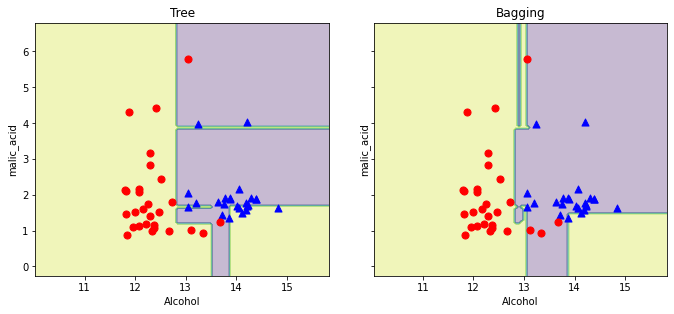

In [10]:
all_clf = [tree, bag]
clf_labels = ["Tree", "Bagging"]

x_min = X[:, 0].min() - 1
x_max = X[:, 0].max() + 1
y_min = X[:, 1].min() - 1
y_max = X[:, 1].max() + 1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(10, 5))

for ax, clf, tt in zip(axarr, all_clf, clf_labels):

    clf.fit(X_train, y_train)    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3)
    
    ax.scatter(X_test[y_test==0, 0], 
                X_test[y_test==0, 1], 
                c='blue', 
                marker='^',
                s=50)
    
    ax.scatter(X_test[y_test==1, 0], 
                X_test[y_test==1, 1], 
                c='red', 
                marker='o',
                s=50)
    
    ax.set_title(tt)
    ax.set_xlabel("Alcohol")
    ax.set_ylabel("malic_acid")

plt.tight_layout(pad=3.0)
plt.show()